# TEST

In [122]:
import os
from datetime import datetime
import json
import requests
from dotenv import load_dotenv
import pandas as pd
from matplotlib import pyplot as plt

In [123]:
load_dotenv()


True

In [124]:
month_val = "2021-03"
symbol = "AAPL"



In [125]:
def parse_json():
    api_key = os.getenv("API_KEY")
    function = "TIME_SERIES_INTRADAY"
    url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&interval=60min&outputsize=full&month={month_val}&apikey={api_key}'
    response = requests.get(url)
    data = response.json()
    return data

In [126]:
#print(parse_json())

In [127]:
def get_df(data):
    time_series_data = data['Time Series (60min)']
    df = pd.DataFrame.from_dict(time_series_data, orient='index')
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df = df.astype(float)
    return df

In [128]:
#print(get_df(parse_json()))

In [129]:
def create_json():
    a_raw = parse_json()
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    file_name = "output" + symbol + month_val + ".json"
    file_path = os.path.join('data', file_name)
    with open(file_path , "w") as json_file:
        json.dump(a_raw, json_file, indent=4)

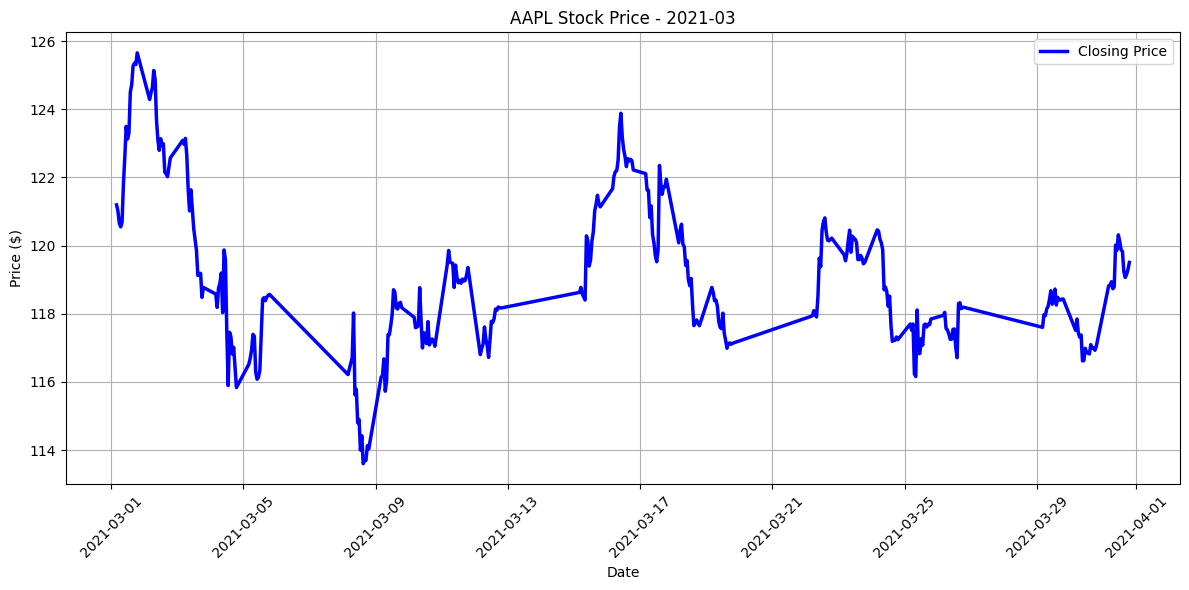

In [130]:
def plot_json():
    file_path = 'data/output' + symbol + month_val + '.json'
    if os.path.exists(file_path):
        with open(file_path) as json_file:
            data = json.load(json_file)
    else:
        create_json()
    with open('data/output' + symbol + month_val + '.json') as json_file:
        json_data = json.load(json_file)
    time_series = json_data['Time Series (60min)']
    dates = list(time_series.keys())
    closing_prices = [float(time_series[date]['4. close']) for date in dates]
    #opening_prices = [float(time_series[date]['1. open']) for date in dates]

    dates = [pd.to_datetime(date) for date in dates]

    plt.figure(figsize=(12, 6))
    plt.plot(dates, closing_prices, color='blue', label='Closing Price', linestyle='-', linewidth=2.5)
    #plt.plot(dates, opening_prices, linestyle='--', color='green', label='Opening Price')
    plt.title(symbol + ' Stock Price - ' + month_val)
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.xticks(rotation=45)
    plt.legend(
        ['Closing Price'],
        loc='upper right'
    )
   # plt.legend(['Opening Price'], loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_json()

In [131]:
from statsmodels.tsa.arima.model import ARIMA

def predict(df, forecast_steps=None):
    closing_prices = df['4. close']
    if forecast_steps is None:
        forecast_steps = len(closing_prices)

    model = ARIMA(closing_prices, order=(30,1,0))
    model_fit = model.fit()

    # Predict for the same period
    predictions = model_fit.predict(start=1, end=len(closing_prices) - 1, typ='levels')

    # Align prediction index with actual data
    predictions.index = closing_prices.index[1:]  # skip first because of differencing

    return closing_prices[1:], predictions


C:\Users\OmerF\Projects\proseminar\zeitreihenanalyse_jupyter\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\OmerF\Projects\proseminar\zeitreihenanalyse_jupyter\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\OmerF\Projects\proseminar\zeitreihenanalyse_jupyter\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


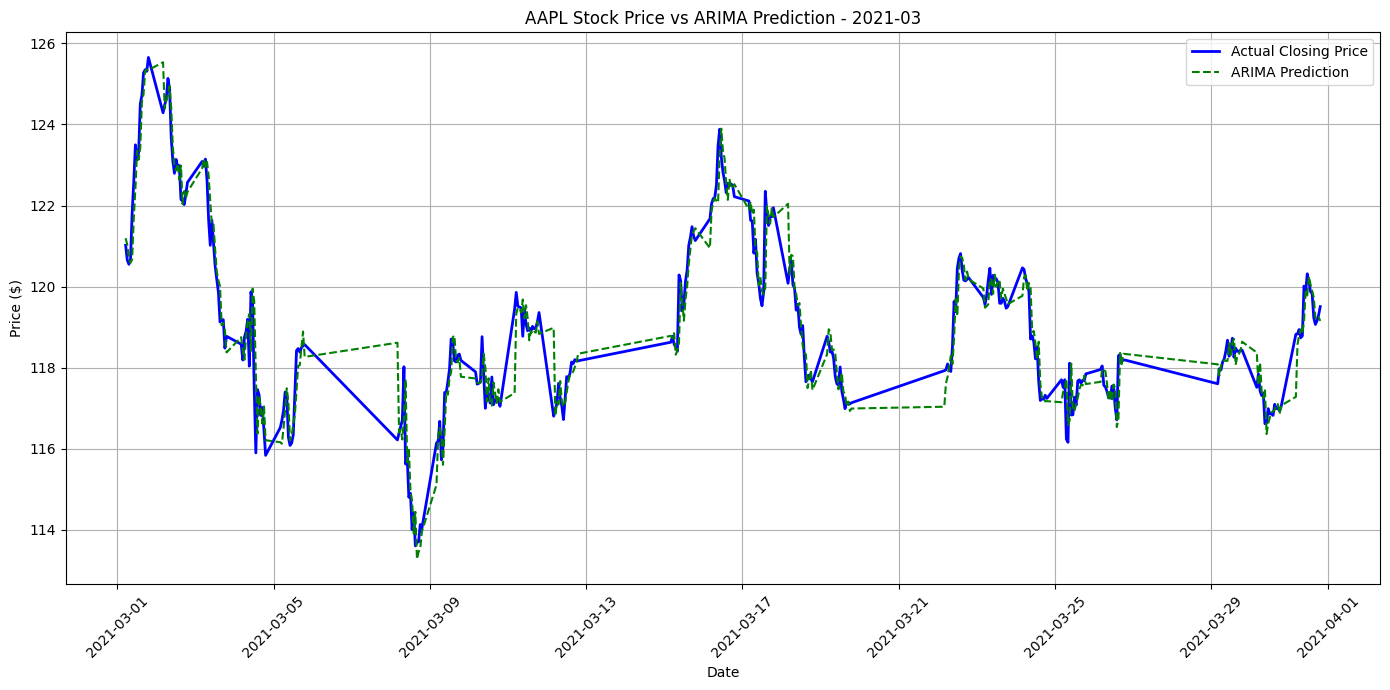

In [132]:
def plot_prediction():
    file_path = 'data/output' + symbol + month_val + '.json'

    if not os.path.exists(file_path):
        create_json()

    with open(file_path) as json_file:
        json_data = json.load(json_file)

    df = get_df(json_data)
    actual, predicted = predict(df)
    plt.figure(figsize=(14, 7))
    plt.plot(actual.index, actual.values, label='Actual Closing Price', linewidth=2, color='blue')
    plt.plot(predicted.index, predicted.values, label='ARIMA Prediction', linestyle='--', color='green')

    plt.title(f'{symbol} Stock Price vs ARIMA Prediction - {month_val}')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_prediction()